In [1]:
# if libraries are not installed, uncomment:

#!pip install pmdarima
#!pip install statsmodels
#!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
import seaborn as sn
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose


# 1. Datos: Precipitaciones, Indicadores Económicos Banco Central

In [2]:
# Banco central
bc = pd.read_csv("banco_central.csv")
# bc.head()

In [3]:
# Precipitaciones 
pp = pd.read_csv('precipitaciones.csv')
#pp.head()

In [4]:
# convertimos columa date a fecha en formato timestamp y ordenamos cronologicamente

def to_date(str_, split=False):
    try:
        return pd.to_datetime(str_, format='%Y-%m-%d')
    except ValueError:
        print("String format not value for datetine: {}".format(str_))
        return None


# Precipitaciones
pp['fecha'] = pp['date'].apply(lambda x: to_date(x))
pp = pp.drop(['date'], axis=1)
pp = pp.sort_values(by=['fecha'])

# Banco central
bc['fecha'] = bc['Periodo'].apply(lambda x: to_date(x.split(' ')[0]))
bc = bc.drop(['Periodo'], axis=1)
bc = bc.sort_values(by=['fecha'])
bc = bc[~bc['fecha'].isnull()]  # eliminación de filas con fechas invalidas

String format not value for datetine: 2020-13-01


## Analisis exploratorio

#### Precipitaciones

In [5]:
# valores faltantes
print(pp.isnull().sum())
print('\n --> No hay valores faltantes')

Coquimbo                               0
Valparaiso                             0
Metropolitana_de_Santiago              0
Libertador_Gral__Bernardo_O_Higgins    0
Maule                                  0
Biobio                                 0
La_Araucania                           0
Los_Rios                               0
fecha                                  0
dtype: int64

 --> No hay valores faltantes


In [6]:
# verificación de valores duplicados
print('valores duplicados:', pp['fecha'].duplicated().sum())

valores duplicados: 0


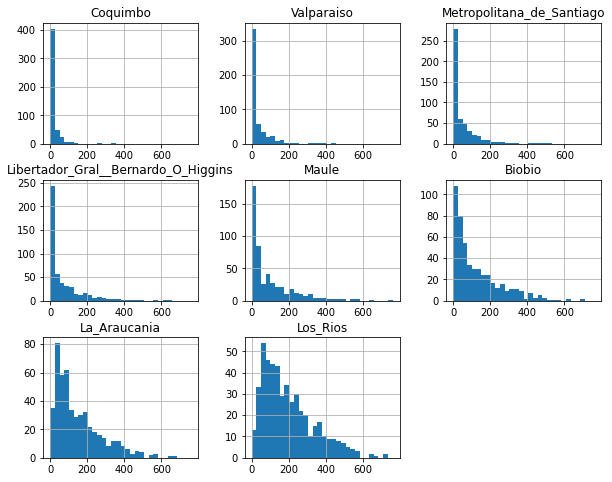

In [7]:
# Distribuciones
pp.hist(bins=30, figsize=(10, 8), cumulative=False,
        range=[0, pp.loc[:, [c for c in pp.columns if c != 'fecha']].max().max()
])
plt.show()

* Se observa una clara tendencia en la cantidad de presipitación respecto la ubicación geográfica. 

* Mientras mas mas al sur la región, mas precipitaciones

#### Banco central

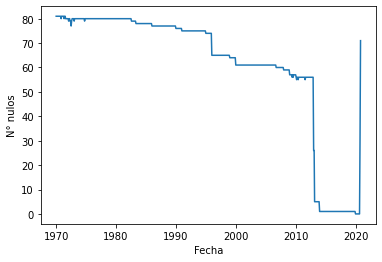

Imacec_empalmado                                   313
Imacec_produccion_de_bienes                        313
Imacec_minero                                      313
Imacec_industria                                   312
Imacec_resto_de_bienes                             313
                                                  ... 
Indice_de_ventas_comercio_real_IVCM                529
Indice_de_ventas_comercio_real_no_durables_IVCM    529
Indice_de_ventas_comercio_real_durables_IVCM       529
Ventas_autos_nuevos                                468
fecha                                                0
Length: 85, dtype: int64


In [8]:
# valores faltantes
plt.plot(bc.fecha, bc.isnull().sum(axis=1))
plt.xlabel('Fecha')
plt.ylabel("N° nulos")
plt.show()

print(bc.isnull().sum())

* Se observa que faltan datos en columnas, debido principalmente a que se registran desde una fecha posterior a la mínima.

In [9]:
# verificación de valores duplicados
print("Filas duplicadas iniciales: {}".format(bc.duplicated().sum()))

# Eliminación de elementos duplicados
bc = bc.drop_duplicates()

# verificación de valores duplicados
print("Filas duplicadas finales: {}".format(bc.duplicated().sum()))

Filas duplicadas iniciales: 2
Filas duplicadas finales: 0


Se observa que muchos de los datos estan en foramto xxx.xxx.xxx, otros con xx.xxx.xxx o incluso con caracteres.
Otros estan en string, pero en formato correcto (x.xx). Más aún, algunas columnas combinan estos formatos.

Dado que no hay consistencia en los formatos, y a que no se cuenta con el método de decodificación, no es popsible hacer un análisis confiable, pues cualquier supopsición para decodificar puede no ser correcta.

Sin embargo, para seguir con el estudio, se harán los siguientes supuestos:
* Los digitos de los valores son correctos, y es el orden de magnitud el incorrecto.
* Los datos son suaves (sin cambios abruptos), por lo que el orden de magnitud de un dato respecto al anterior es el mínimo posible.

En base a esto, se procede como sigue:
0. Se eliminan las filas duplicadas
1. Se asume que los valores iniciales tienen un orden de magnitud cercano 2
2. Se recorre la columna en orden cronológico.
3. Para cada valor, se extraen los digitos (sin puntos)
4. Se crea un arreglo con este valor, pero con distintos ordenes de magnitud.
5. Se asigna como valor aquel que tenga el orden de magnitud mas similar al valor anterior
6. Valores 0 son anulados (en general los indices no tienen valores = 0)

In [10]:
def clean_colum(col_):
    col_copy = col_.copy()
    ref = 100
    for i in range(len(col_)):
        val = col_.iloc[i]
        str_val = str(val).replace('.', '')
        if not str_val.isdigit() or float(str_val) == 0:
            val_new = np.nan
        else:
            float_val = float(str_val) / 10**(len(str_val))
            vals = [float_val*10**(k) for k in range(1, 6)]
            #dists = [np.abs(ref - vali) for vali in vals]
            dists = [np.abs(np.log(ref/vali)) for vali in vals]
            val_new = vals[int(np.argmin(dists))]
            ref = val_new
        col_copy.iloc[i] = val_new
    return col_copy.astype('float64')
        
for c in bc.columns:
    if c == 'fecha':
        continue
    bc[c] = clean_colum(bc[c])

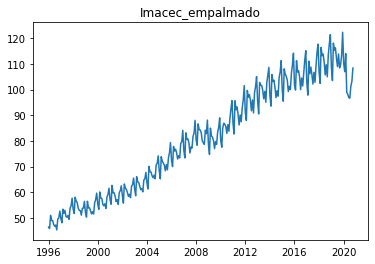

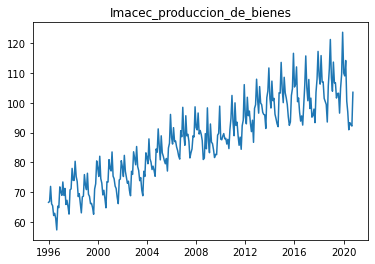

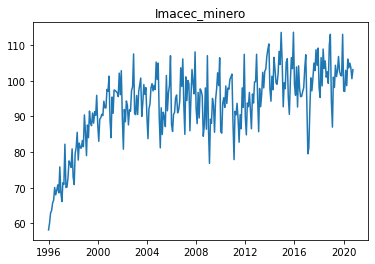

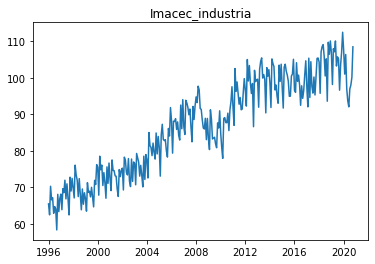

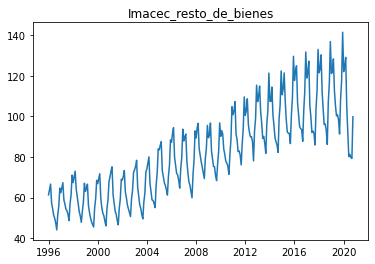

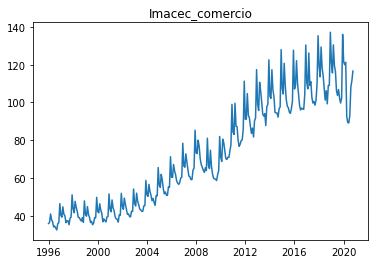

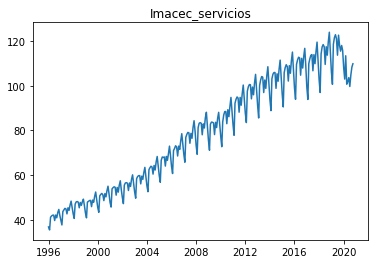

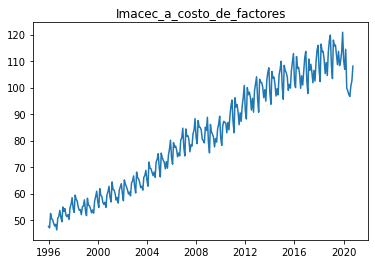

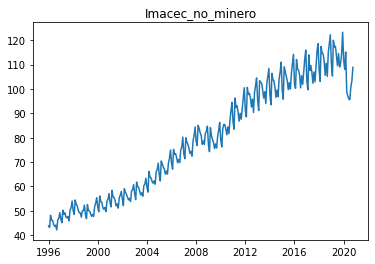

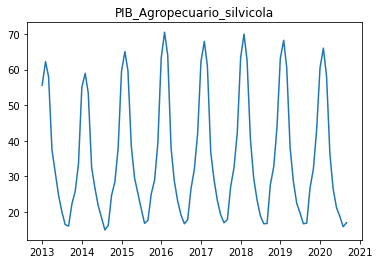

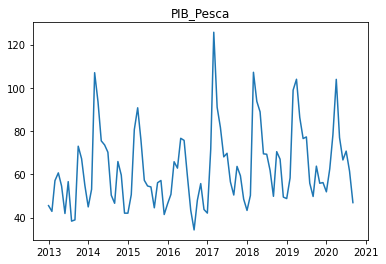

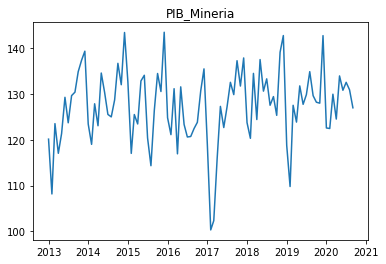

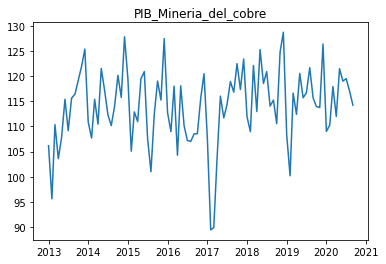

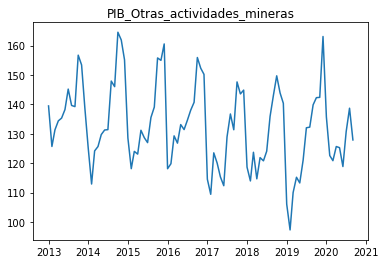

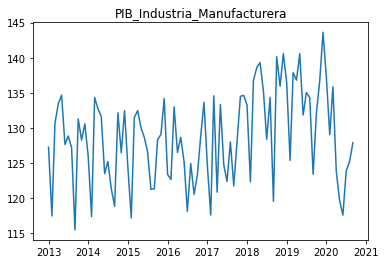

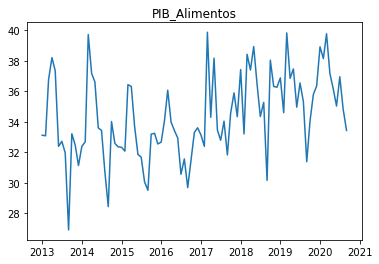

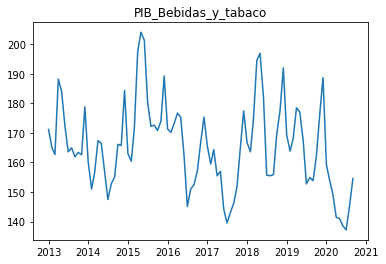

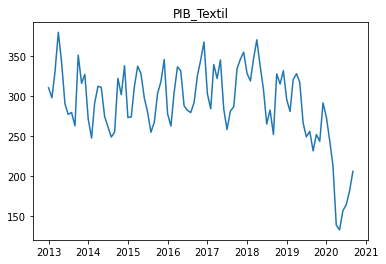

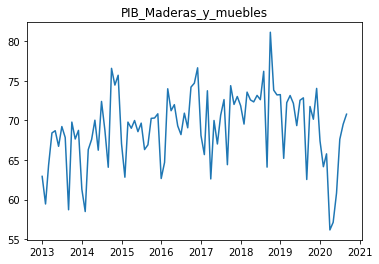

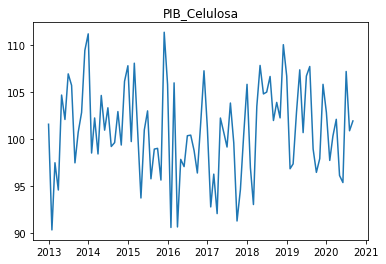

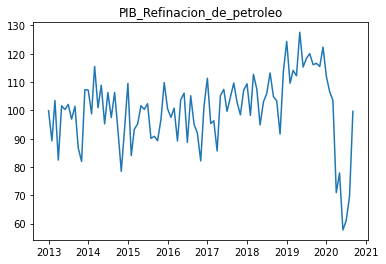

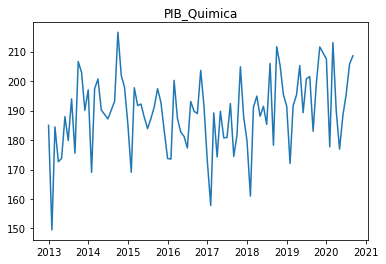

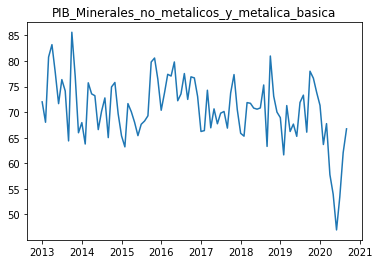

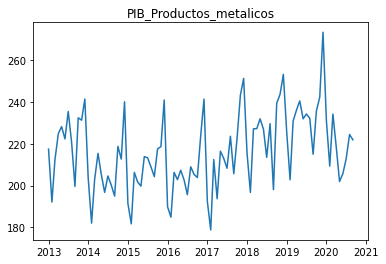

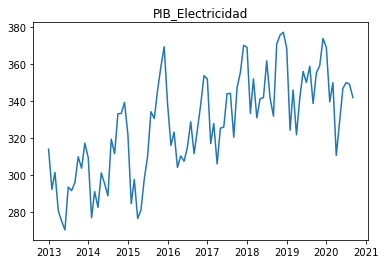

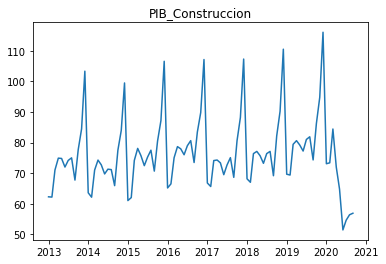

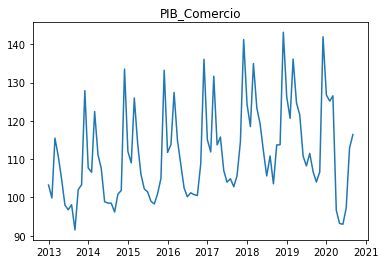

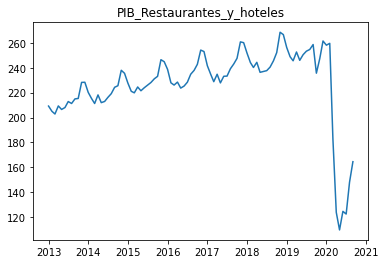

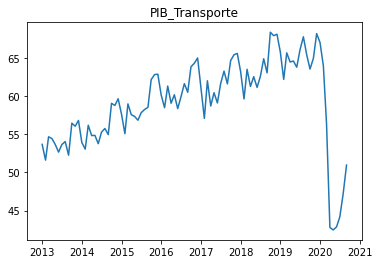

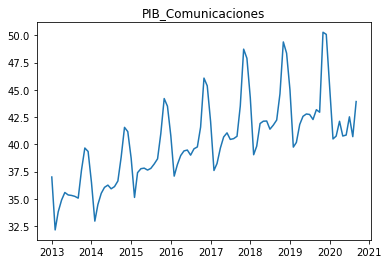

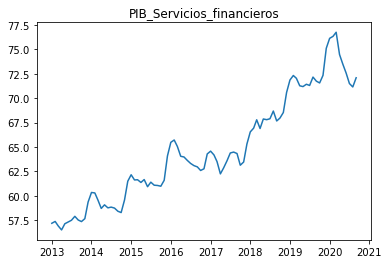

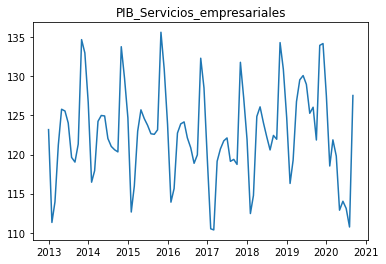

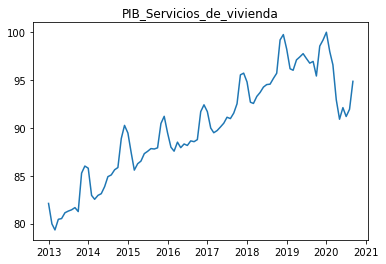

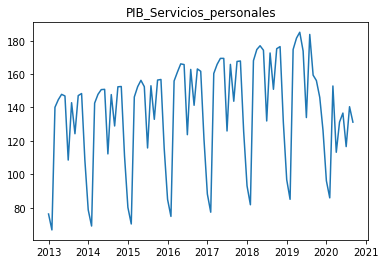

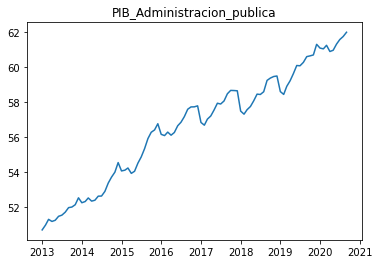

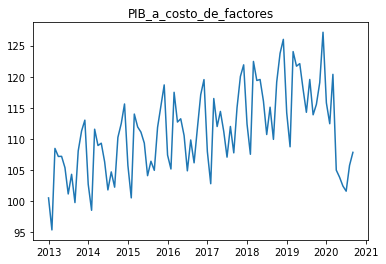

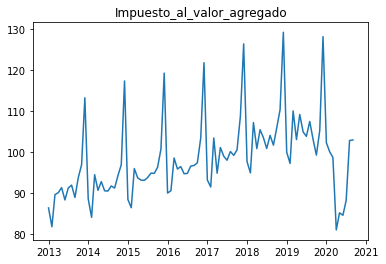

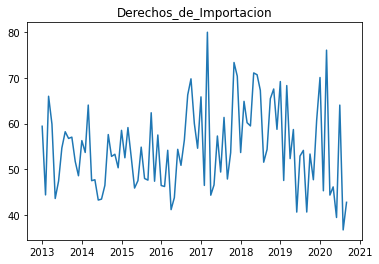

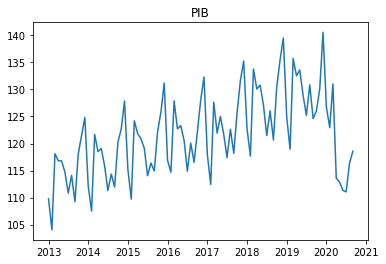

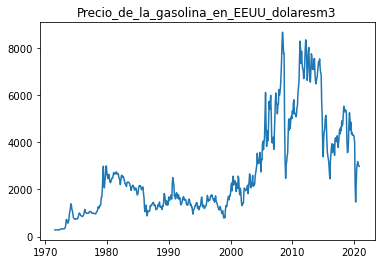

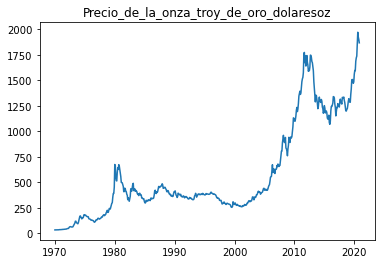

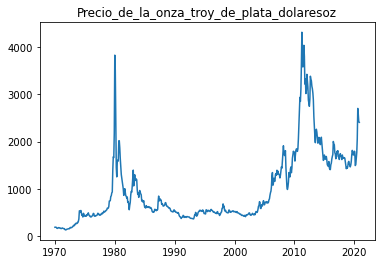

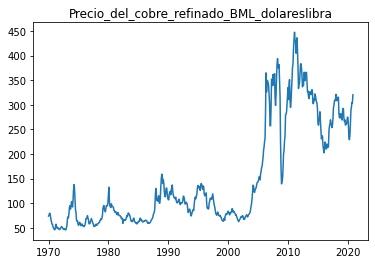

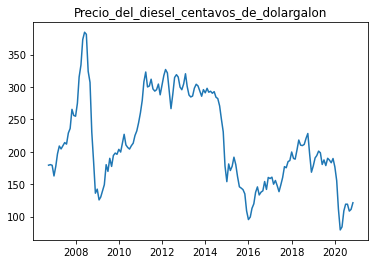

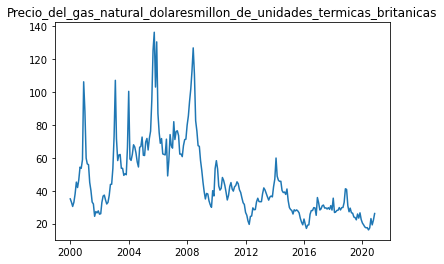

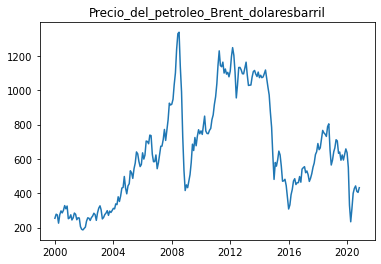

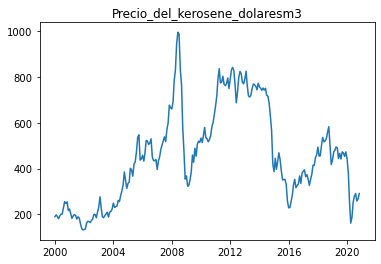

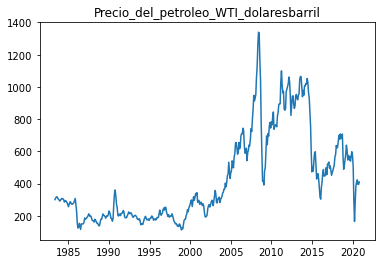

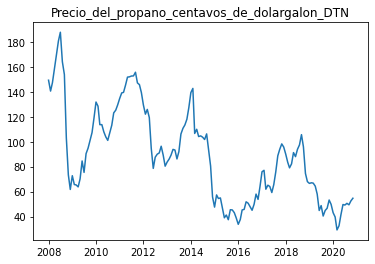

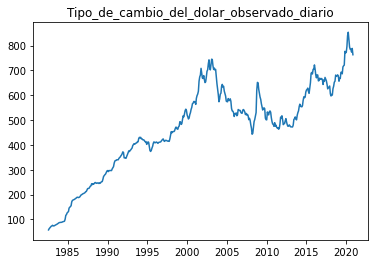

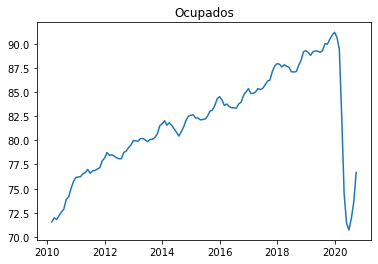

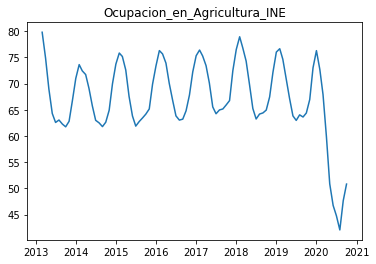

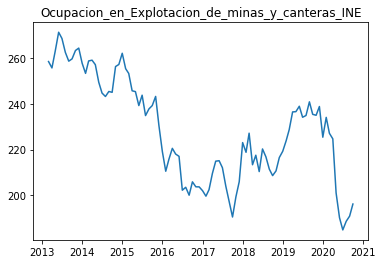

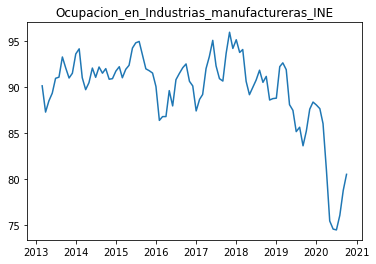

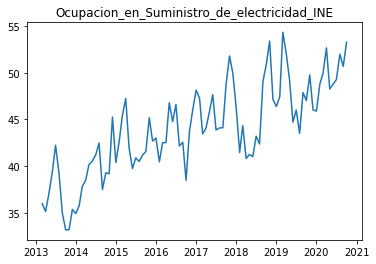

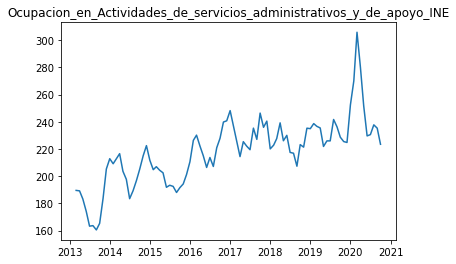

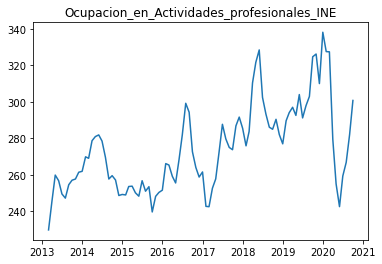

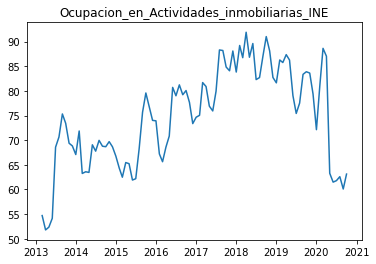

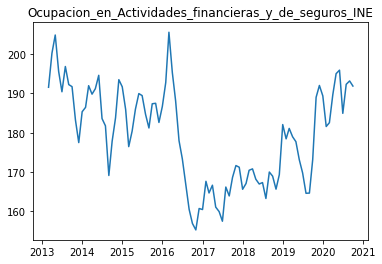

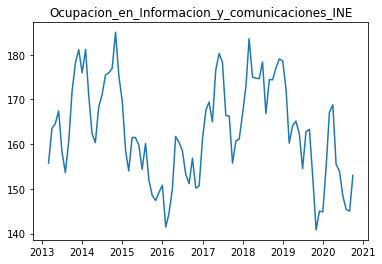

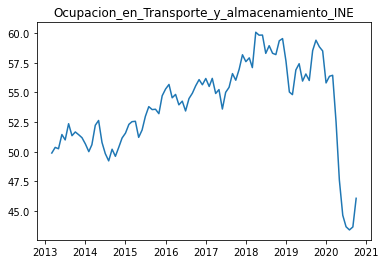

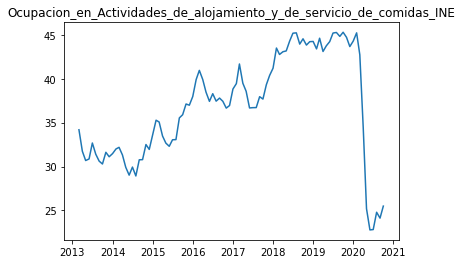

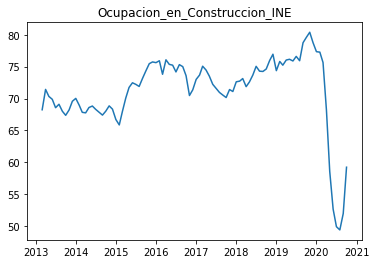

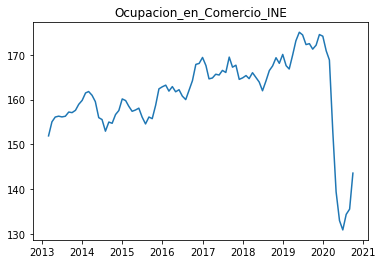

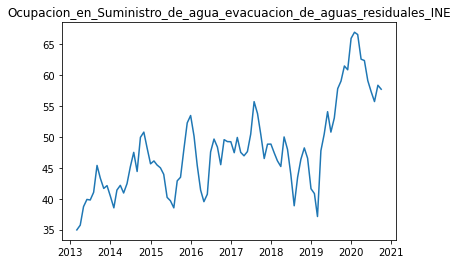

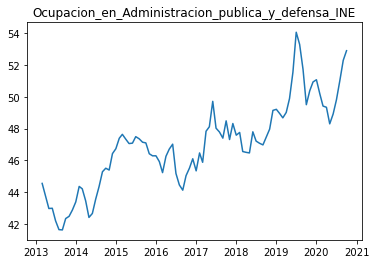

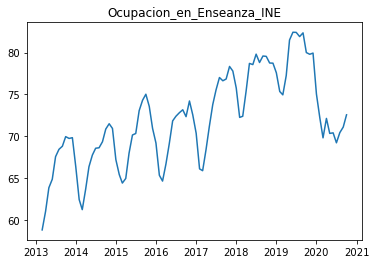

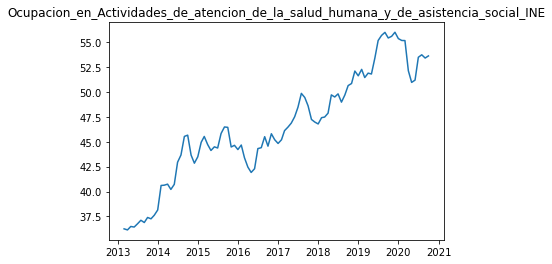

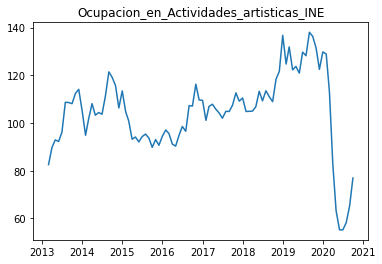

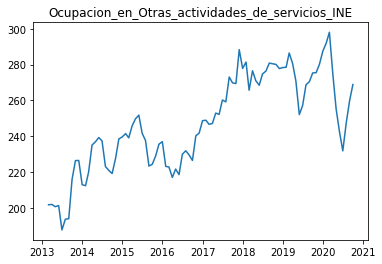

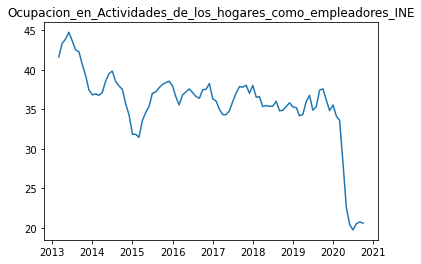

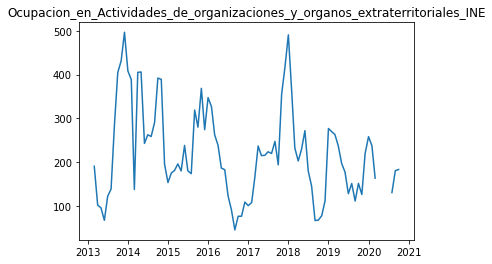

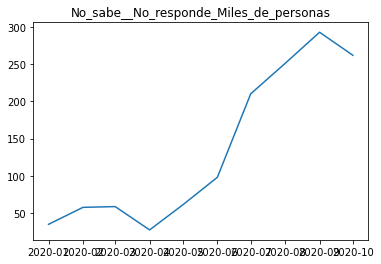

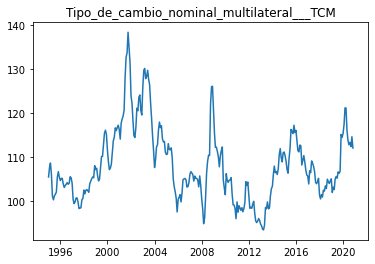

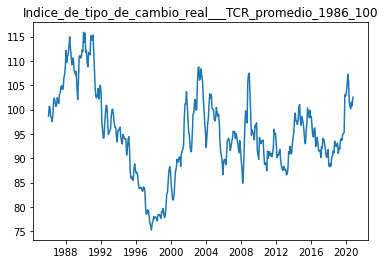

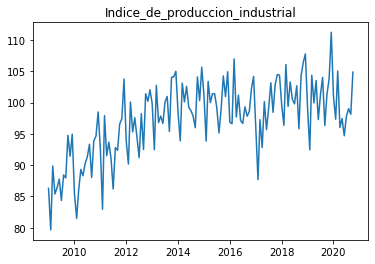

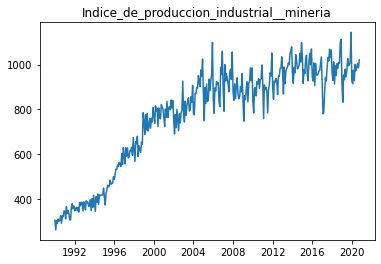

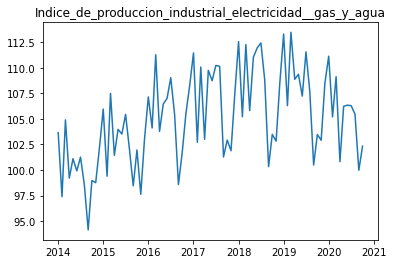

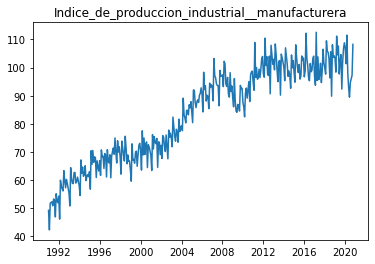

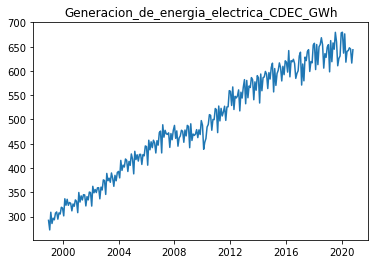

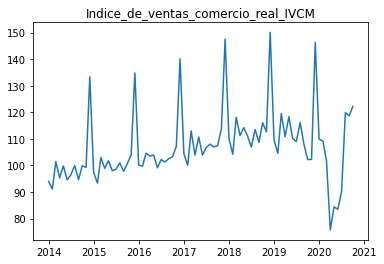

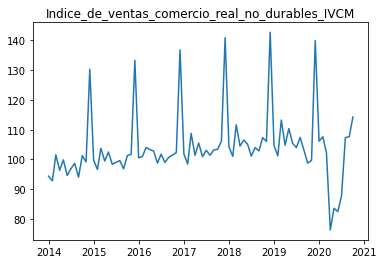

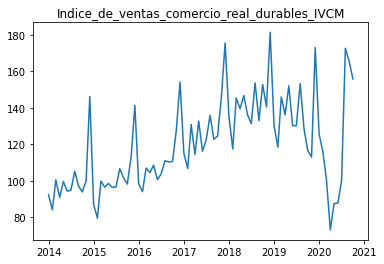

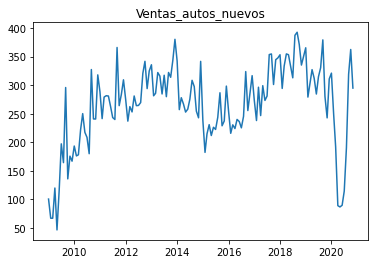

In [11]:
for c in bc.columns:
    if c == 'fecha':
        continue
    plt.plot(bc.fecha, bc[c])
    plt.title(c)
    plt.show()

Sobre los datos presentados, se observa lo siguiente:

1. En general tienen un comportamiento esperado. Algunos graficos presentan cambios abruptos, pero coinciden en las fechas 2009 o 2020 (gran recesion y comienzo de pandemia, respectivamente). Se observa que el precio del petroleo (y derivados) y del cobre se vieron afectados en la gran recesión. 

2. Se observa periodicidad estacional en graficos como Imacec (y derivados), la mayoria de los PIB, IVA, entre otros.

# 3. Visualización

In [12]:
# graficar series históricas de precipitaciones para un rango de fechas determinado
def filter_df(df, region, fecha_inicio, fecha_termino, date_in=True):
    fecha_inicio = pd.to_datetime(fecha_inicio, format='%Y-%m-%d')
    fecha_termino = pd.to_datetime(fecha_termino, format='%Y-%m-%d')

    assert region in df.columns
    if date_in:
        assert len(df[df['fecha'] == fecha_inicio])>0
        assert len(df[df['fecha'] == fecha_termino])>0
    return df[['fecha', region]][(df['fecha']>=fecha_inicio) & (df['fecha'] <= fecha_termino)]


f_init = '2000-01-01'
f_end = '2020-01-01'
lbo = filter_df(pp, 'Libertador_Gral__Bernardo_O_Higgins', f_init, f_end)
rm = filter_df(pp, 'Metropolitana_de_Santiago', f_init, f_end)

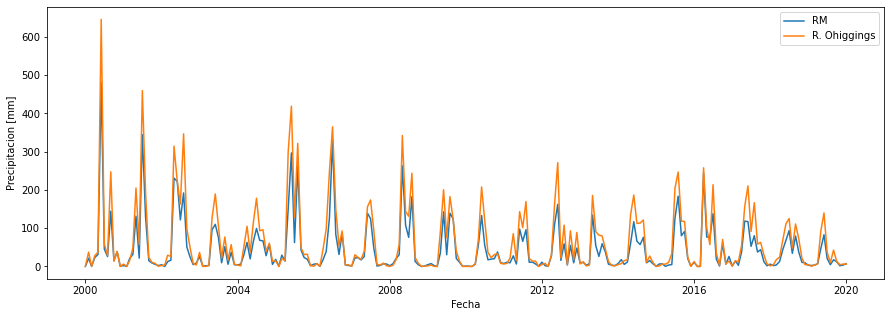

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(rm.fecha, rm['Metropolitana_de_Santiago'], label='RM')
plt.plot(lbo.fecha, lbo['Libertador_Gral__Bernardo_O_Higgins'], label='R. Ohiggings')
plt.legend()
plt.ylabel('Precipitacion [mm]')
plt.xlabel('Fecha')
plt.show()

* En primer lugar, se observa una alta correlación entre la precipitación de la RM y en la region L. B. O'higgins

* Se observa una marcada tendencia a ciclos estacionales, donde tiende a haber una mayor precipitación los meses de invierno, y una menor los meses de verano.

* Ademas se observa una tendendia en ambas regiones a disminuir sus precipitaciones, probablemente debido al cambio climático.

* Por último, se observa una leve periodicidad en las precipitaciones máximas y mínimas. Podría deberse a los efectos de las corrientes del niño y de la niña, aunque se requiere una mayor profundización en esto.

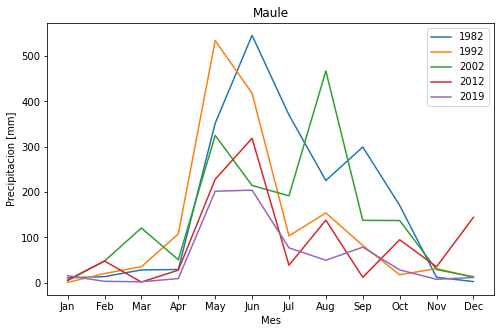

In [14]:
# graficar múltiples series de tiempo mensuales de precipitaciones, donde cada serie de tiempo corresponda a un año

def plot_series_mensuales(df, region, years, date_in=False):
    plt.figure(figsize=(8, 5))
    x_axis = [pd.to_datetime("2000-%d-01" % i, format='%Y-%m-%d') for i in range(1, 13)]
    x_axis = [xi.strftime("%b") for xi in x_axis]
    for year in years:
        f_init = '%d-01-01' % year
        f_end = '%d-12-31' % year
        lbo_i = filter_df(pp, region, f_init, f_end, date_in=date_in)
        plt.plot(x_axis, lbo_i[region], label=year)
    plt.legend()
    plt.xlabel("Mes")
    plt.ylabel('Precipitacion [mm]')
    plt.title(region)
    plt.show()
    
plot_series_mensuales(pp, 'Maule', [1982, 1992, 2002, 2012, 2019])

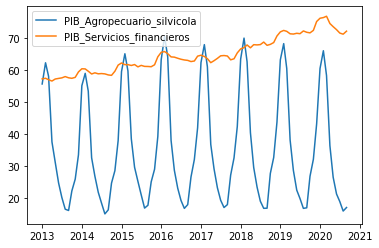

In [15]:
# visualizacion de dos (o mas) series históricas para un rango de fechas determinado
def viualize(df, fecha_inicio, fecha_termino, columnas):
    '''
    función que permite visualizar dos series históricas de PIB para un rango de
    fechas determinado. Para esto la función debe recibir como input el nombre de cada
    serie, fecha de inicio y fecha de término.
    '''
    fecha_inicio = pd.to_datetime(fecha_inicio, format='%Y-%m-%d')
    fecha_termino = pd.to_datetime(fecha_termino, format='%Y-%m-%d')

    for col in columnas:
        assert col in df.columns
    
    df_tmp = df[(df['fecha']>=fecha_inicio) & (df['fecha'] <= fecha_termino)]
    
    for col in columnas:
        t = df_tmp['fecha']
        v = df_tmp[col]
        plt.plot(t, v, label=col)
    plt.legend()
    plt.show()
    
viualize(bc, '2013-01-01', '2022-01-01', ['PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros'])    
   

* Se observa en ambas un comportamiento cíclico, sin embargo el PIB de servicios financieros presenta una tendencia al alza, mientras que el PIB agropecuario y silvicola es mas estable.


# 4. Tratamiento y creación de variables

#### ¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo se tienen que correlacionar para entrenar un modelo?

Una forma de evaluar la correlación entre series de tiempo es con correlación cruzazda (o croscorrelación), que es la correlación entre dos series temporales, tanto en tiempo simultáneo como desfasadas. Para aplicar este test, las series deben ser estacionarias.*

Para entrenar un modelo, las variables independientes no deben estar correlacionadas, ya que si lo están puede haber colinealidad. La colinealidad es la existencia de una asociación lineal entre el conjunto de las variables independientes. Esto afecta principalmente a metodos de regresión lineal. 

Para medir la colinealidad, se puede calcular la correlación R entre dos variables, y luego la tolerancia (1-R2). Si la tolerancia es menor a 0.1, suele considerarse que las variables son colineales.

*Guevara Díaz, J. M. (2014). Uso correcto de la correlación cruzada en Climatología: el caso de la presión atmosférica entre Taití y Darwin. Terra, 30(47), 79-102.

In [16]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

def max_crosscorr(datax, datay):
    corrs = [crosscorr(datax, datay, lag=i) for i in range(12)]
    lag = np.argmax(corrs)
    return corrs[int(lag)], lag
    
def tolerancia(datax, datay):
    R, lag = max_crosscorr(datax, datay)
    return (1 - R**2), lag

In [17]:
# lectura precio leche
pl = pd.read_csv('precio_leche.csv')
pl.head()

,Anio,Mes,Precio_leche
0,1979,Ene,3.85
1,1979,Feb,4.58
2,1979,Mar,5.18
3,1979,Abr,6.06
4,1979,May,7.25


In [18]:
# creacion columa fecha
month_number = {'Ene':1, 'Feb':2, 'Mar':3, 'Abr':4, 'May':5, 'Jun':6 , 'Jul':7 , 'Ago':8 , 'Sep':9 , 'Oct':10 ,
               'Nov':11 , 'Dic':12}

pl['fecha'] = pl.apply(lambda x: to_date("%s-%s-01" % (x['Anio'], month_number[x['Mes']])),
                     axis=1)
pl = pl.drop(['Anio', 'Mes'], axis=1)
pl = pl.sort_values(by=['fecha'])



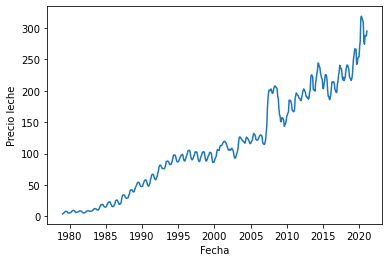

In [19]:
plt.plot(pl.fecha, pl.Precio_leche)
plt.xlabel('Fecha')
plt.ylabel('Precio leche')
plt.show()

* Se observa que el precio no es una serie estacionaria, sin embargo se puede tranformar para que lo sea.

In [20]:
# Union de tablas
data  = pd.merge(pd.merge(pl, pp, on='fecha'), bc, on='fecha')

# Variables año, mes, trimetre
data['anio'] = data['fecha'].apply(lambda x: x.year)
data['mes'] = data['fecha'].apply(lambda x: x.month)
data['trimestre'] = data['fecha'].apply(lambda x: (x.month-1)//3 + 1)

### Selección de variables

La selección de variables se realiza en base a factores que afectan la producción de leche (precipitaciones), asi como factores economicos que describen, indirectamente, el comercio de la la leche (PIB agropecuario, Imacec comercio, OIB comercio)

Luego, se verificará que estas sean estacionarias para poder computar la crosscorrelacion. Si no lo son, se hará una diferenciación de un orden para que sean estacionarias. 

In [21]:
selected_var = ["Imacec_resto_de_bienes",
                "PIB_Agropecuario_silvicola",
                "Los_Rios",
                "La_Araucania",
                "Biobio",
                "Maule",
                "Imacec_comercio",
                "Libertador_Gral__Bernardo_O_Higgins",
                "Metropolitana_de_Santiago",
                "PIB_Comercio",
                "Valparaiso",
                "Ocupacion_en_Agricultura_INE",
                "Coquimbo", 
                "anio",
                'mes',
                'trimestre']

In [22]:
sel_data = data[selected_var + ['Precio_leche', 'fecha']]
print("Total rows: {}".format(data.shape[0]))
print(sel_data.isnull().sum())

# Como PIB_Agropecuario_silvicola, PIB_Comercio y Ocupacion_en_Agricultura_INE
# tienen menos de 100 datos, se eliminan de la seleccion

for col in sel_data.columns:
    if sel_data[col].isnull().sum() > 400:
        sel_data.drop(col, inplace=True, axis=1)
       
 # eliminación de datos nulos
limit_date = sel_data[sel_data.Imacec_comercio.isnull()]['fecha'].max()
sel_data = sel_data[sel_data['fecha'] > limit_date]
sel_data.shape

Total rows: 496
Imacec_resto_de_bienes                 204
PIB_Agropecuario_silvicola             408
Los_Rios                                 0
La_Araucania                             0
Biobio                                   0
Maule                                    0
Imacec_comercio                        204
Libertador_Gral__Bernardo_O_Higgins      0
Metropolitana_de_Santiago                0
PIB_Comercio                           408
Valparaiso                               0
Ocupacion_en_Agricultura_INE           410
Coquimbo                                 0
anio                                     0
mes                                      0
trimestre                                0
Precio_leche                             0
fecha                                    0
dtype: int64


/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(292, 15)

#### Estudio de estacionalidad

Se utiliza el test Dickey-Fuller para verificar si las series son estacionarias. Según el test, el parametro "Test Statistic" debe ser menor que los valores criticos para que una serie sea estacionaria. Idealmente debe ser menor que los 3 (que representan los intervalos de confianza). Ademas, el p-value debe ser menor a 0.05.

In [23]:
# Dickey-Fuller test:
print ('Resultados del test Dickey-Fuller:')
timeseries = sel_data.Precio_leche.values
dftest = adfuller(timeseries, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

print("\n-> El precio de la leche no es estacionario")

Resultados del test Dickey-Fuller:
Test Statistic                   0.461614
p-value                          0.983658
#Lags Used                      16.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64

-> El precio de la leche no es estacionario


Se realiza una transformació al precio de la leche para que sea estacionario. Esta transformación consiste en calcular la diferencia de un orden de la serie.

In [24]:
def is_stationary(timeserie):
    '''
    Comprueba si una serie de tiempo es estacionaria o no, en función del test Dickey-Fuller.
    '''
    dftest = adfuller(timeserie.values, autolag='AIC')
    test = dftest[0]
    p_val = dftest[1]
    crit_val_1 = dftest[4]['1%']
    return (test < crit_val_1) and p_val < 0.05

def get_diff(timeserie):
    diff = np.zeros_like(timeserie.values)
    diff[1::] = timeserie.values[1::] - timeserie.values[0:-1]
    return diff

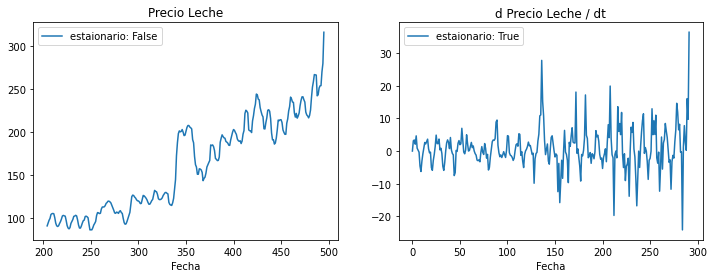

In [25]:
diff = get_diff(sel_data.Precio_leche)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
statn = is_stationary(sel_data.Precio_leche)
plt.plot(sel_data.Precio_leche, label='estaionario: {}'.format(statn))
plt.title('Precio Leche')
plt.legend()
plt.xlabel('Fecha')

plt.subplot(1,2,2)
statn = is_stationary(pd.DataFrame(diff))
plt.plot(diff, label='estaionario: {}'.format(statn))
plt.title('d Precio Leche / dt')
plt.xlabel('Fecha')
plt.legend()
plt.show()


sel_data['dPrecio_leche'] = diff

* Al diferenciar, el precio de la leche si es estacionario.

* Verificamos que las variables idependientes sean estacionarias. Si no lo son, las diferenciamos e incluimos si la nueva señas es estacionaria.

In [26]:
statn_data = sel_data[['fecha', 'dPrecio_leche']]
statn_data.set_index('fecha')
for col in sel_data.columns:
    if col in ['fecha', 'dPrecio_leche', 'Precio_leche']:
        continue
    variable = sel_data[col].fillna(0)
    statn = is_stationary(variable)
    if statn:
        statn_data[col] = data[col]
        continue
    diff = get_diff(variable)
    statn = is_stationary(pd.DataFrame(diff))
    if statn:
        statn_data["d_{}".format(col)] = diff
        print("d_{}".format(col), statn)

d_Imacec_resto_de_bienes True
d_anio True


/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

* Ya seleccionadas las variables y calculada su diferenia en casos donde sea necesario, procedemos a calcular la croscorrelacion entre ellas para luego filtrar aquellas con correlación alta. Para esto se calculará la tolerancia (1 - R2), la cual debe ser < 0.1 para considerar que dos series con colineales.

<AxesSubplot:title={'center':'Matriz de confución de Tolerancia entre variables'}>

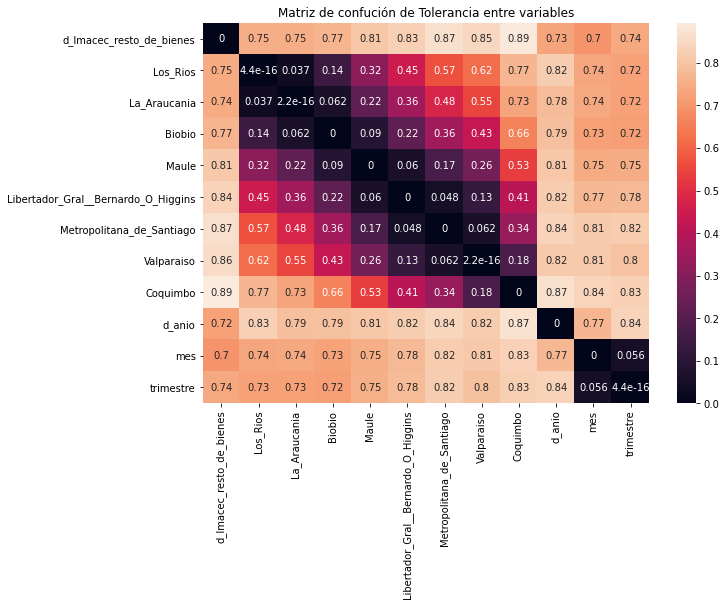

In [27]:
selected_vars = [col for col in statn_data.columns if col not in ['dPrecio_leche', 'fecha']]

conf_matrix = np.zeros((len(selected_vars), len(selected_vars)))
for k1, var1 in enumerate(selected_vars):
    for k2, var2 in enumerate(selected_vars):
        tmp = statn_data[[var1, var2]]
        tmp = tmp.fillna(0)
        tmp = tmp[(tmp[var1]>0) & (tmp[var2]>0)]  
        tol, lag = tolerancia(statn_data[var1], statn_data[var2])
        conf_matrix[k1, k2] = tol

df_cm = pd.DataFrame(conf_matrix, index = [i for i in selected_vars],
                  columns = [i for i in selected_vars])
plt.figure(figsize = (10,7))
plt.title("Matriz de confución de Tolerancia entre variables")
sn.heatmap(df_cm, annot=True)

Se observa una alta correlación (baja tolerancia) entre las precipitaciones, principalmente en aquellas al sur de santiago.

En primer lugar se escoge la region de los rios, por tener el mayor porcentaje de producción de leche. Luego, dejamos fuer a la Araucania por tener una tolerancia de 0.06 (~ 0.1) respecto a Los Rios. Idem con Bio-Bio.

Siguiendo esta regla, incluímos a la region Libertador BH, eliminamos Maule, RM, Valparaiso, y la variable mes

<AxesSubplot:title={'center':'Matriz de confución de Tolerancia entre variables'}>

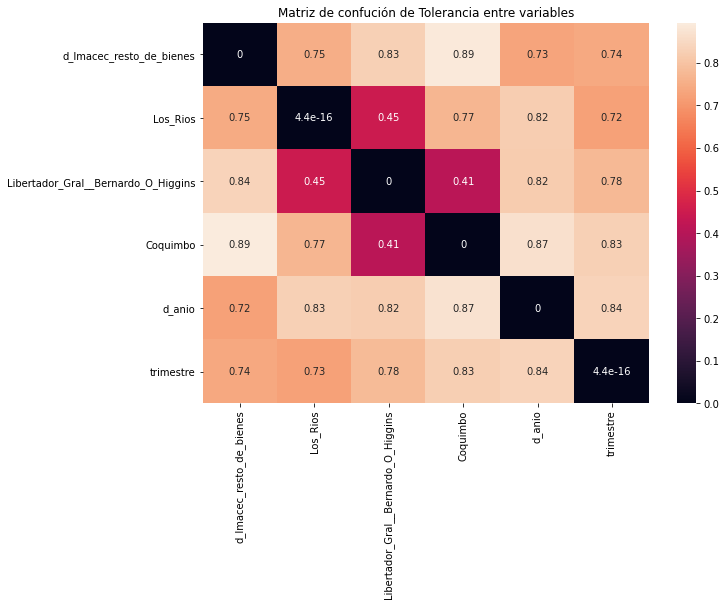

In [28]:
selected_vars = [col for col in statn_data.columns if col not in ['dPrecio_leche', 'fecha', 'Biobio', 
                                                                  'La_Araucania', 'Maule',
                                                                  'Metropolitana_de_Santiago',
                                                                  'Valparaiso',
                                                                  'mes']]

conf_matrix = np.zeros((len(selected_vars), len(selected_vars)))
for k1, var1 in enumerate(selected_vars):
    for k2, var2 in enumerate(selected_vars):
        tmp = statn_data[[var1, var2]]
        tmp = tmp.fillna(0)
        tmp = tmp[(tmp[var1]>0) & (tmp[var2]>0)]  
        tol, lag = tolerancia(statn_data[var1], statn_data[var2])
        conf_matrix[k1, k2] = tol

df_cm = pd.DataFrame(conf_matrix, index = [i for i in selected_vars],
                  columns = [i for i in selected_vars])
plt.figure(figsize = (10,7))
plt.title("Matriz de confución de Tolerancia entre variables")
sn.heatmap(df_cm, annot=True)

In [29]:
dataset = sel_data[[var.replace('d_', '') for var in selected_vars] + ['Precio_leche', 'fecha']]
statn_dataset = statn_data[selected_vars + ['dPrecio_leche', 'fecha']]



# 5. Modelo

En primer lugar, construiremos un modelo ARIMA "Auto Regressive Integrated Moving Average". Es decir, construiremos un modelo que predice datos futuros en función de los pasados.

En primer lugar estudiaremos la presencia de estacionalidad en el precio de la leche, para luego definir si usar ARIMA, o SARIMA (Seasonal ARIMA)

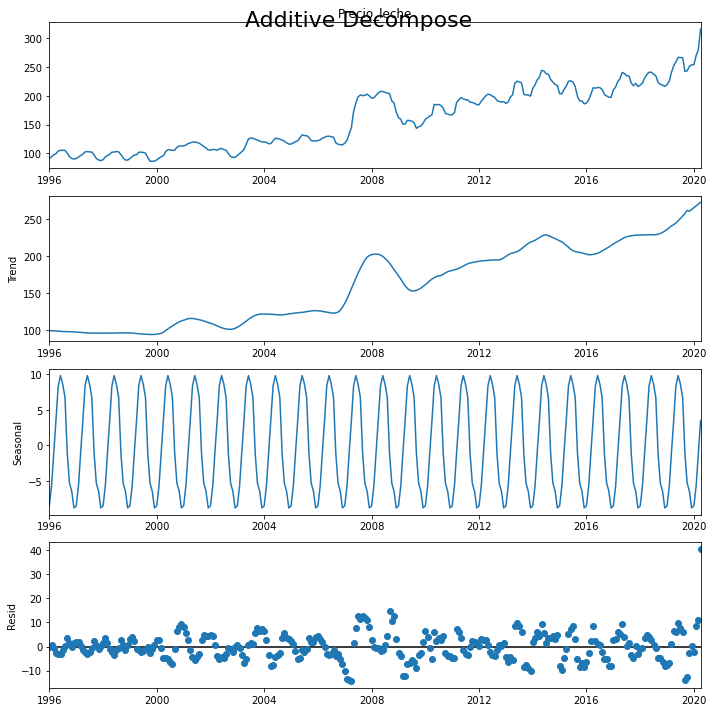

In [30]:
tmp = dataset.set_index('fecha')
result_add = seasonal_decompose(tmp['Precio_leche'], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

* Se observa una componente estacional, por lo que se utilizará un modelo SARIMA para la predicción.

### Base de datos

In [51]:
# Se usará un metodo de optimización de parametros de SARIMA que busca el orden de la diferencia a utilizar, 
# por lo que utilizamos la serie original para Precio leche.

# Se usa el 25% de los datos finales para test. No se selecciona un 25% aleatorio ya que la serie de tiempo
# tiene un orden cronologico, y al seleccionar de forma aleatoria, la información de orden cronologico se pierde

# Alternativas para realziar un cross-validation son:
#    - Time Series Split Cross-Validation
#    - Blocked Cross-Validation

# Usamos el dataset truncado (sin valores nulos en las variables independientes) en el modelo SARIMA,
# pese a poder utilizar la serie completa, para una posterior comparación con SARIMAX 
# (modelo con variables exogenas)
val_l = int(len(dataset.Precio_leche) * 25 / 100)
train = dataset[0:-val_l]
test = dataset[-val_l::]


## Metricas

Algunas metricas a utilizar pueden ser:

1. Mean Absolute Percentage Error (MAPE)
2. Correlación entre la serie real y la predicción (corr)
3. Min-Max Error (minmax)


In [32]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print('mape: {}\ncorr: {}\nmin-max: {}'.format(mape, corr, minmax))


### Modelo ARIMA

In [33]:
# Busqueda de parametros

smodel = pm.auto_arima(train.Precio_leche, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1895.632, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1277.204, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1909.958, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1328.458, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1226.512, Time=0.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1201.036, Time=0.72 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1208.471, Time=0.70 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=1202.852, Time=1.03 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1207.313, Time=1.63 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=1147.709, Time=0.72 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=1156.669, Time=1.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  219
Model:             SARIMAX(3, 0, 0)x(2, 1, [1], 12)   Log Likelihood                -562.967
Date:                              Mon, 19 Apr 2021   AIC                           1141.935
Time:                                      22:21:41   BIC                           1168.597
Sample:                                           0   HQIC                          1152.717
                                              - 219                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4285      0.231      1.853      0.064      -0.025       0.882
ar.L1          1.3599      0.057     23.720      0.000       1.248       1.472
ar.L2         -0.2027      0.101     -2.012      0.044      -0.400      -0.005
ar.L3         -0.1926      0.058     -3.300      0.001      -0.307      -0.078
ar.S.L12      -0.4083      0.108     -3.783      0.000      -0.620      -0.197
ar.S.L24      -0.3261      0.074     -4.385      0.000      -0.472      -0.180
ma.S.L12      -0.5651      0.109     -5.177      0.000      -0.779      -0.351
sigma2        12.3162      0.847     14.535      0.000      10.655      13.977
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               215.00
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.81   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

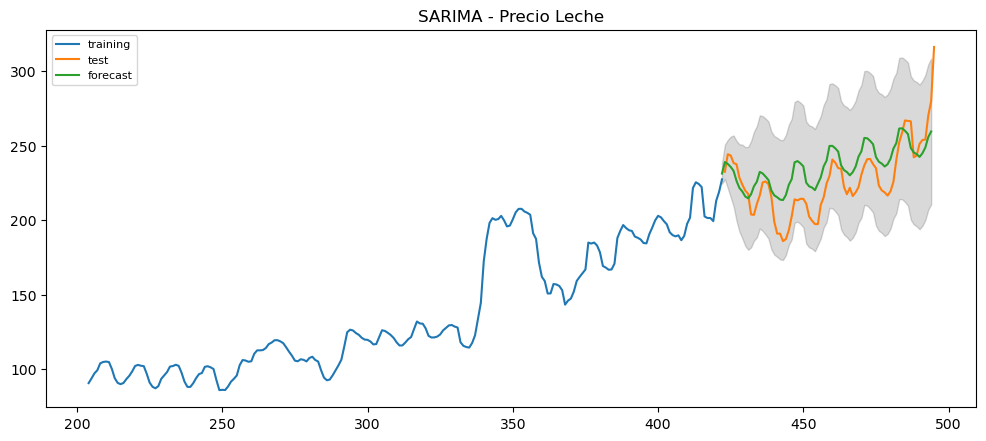

Metric Results:

mape: 0.06281035792669648
corr: 0.8471176379149982
min-max: 0.05840411572883342


/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [34]:
# Forecast
n_periods = val_l
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(train.index[-1], train.index[-1]+n_periods)


# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.Precio_leche, label='training')
plt.plot(test.Precio_leche, label='test')
plt.plot(fitted_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title("SARIMA - Precio Leche")
plt.legend(loc='upper left', fontsize=8)
plt.show()


print("Metric Results:\n")
forecast_accuracy(fitted_series, test.Precio_leche.values)

## Variables exógenas

Al incluir variables exógenas al modelo, se debe usar un modelo SARIMAX (SARIMA + Varibales exogenas)

In [35]:
tmp_data = statn_dataset.copy()
tmp_data = pd.merge(tmp_data, dataset[['Precio_leche', 'fecha']], how='left', on='fecha')

val_l = int(len(tmp_data) * 25/100)
train = tmp_data[0:-val_l]
test = tmp_data[-val_l::]

exog_vars = train.columns.drop(['fecha', 'dPrecio_leche', 'Precio_leche'])
train.shape, test.shape

y_value = 'Precio_leche'
print(exog_vars)

Index(['d_Imacec_resto_de_bienes', 'Los_Rios',
       'Libertador_Gral__Bernardo_O_Higgins', 'Coquimbo', 'd_anio',
       'trimestre'],
      dtype='object')


In [36]:
# SARIMAX Model
sxmodel = pm.auto_arima(train[y_value], exogenous=train[exog_vars],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1192.063, Time=1.60 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1903.370, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1287.201, Time=1.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1918.246, Time=0.30 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1293.291, Time=0.70 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1189.746, Time=2.00 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1245.564, Time=1.49 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1185.912, Time=2.37 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1202.288, Time=2.16 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=1183.783, Time=2.72 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1200.356, Time=2.42 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=1233.631, Time=2.30 sec
 ARIMA(2,0,1)(2,1,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  219
Model:             SARIMAX(2, 0, 0)x(2, 1, [1, 2], 12)   Log Likelihood                -572.480
Date:                                 Mon, 19 Apr 2021   AIC                           1172.959
Time:                                         22:22:32   BIC                           1219.617
Sample:                                              0   HQIC                          1191.828
                                                 - 219                                         
Covariance Type:                                   opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
intercept                               0.8864      0.389      2.277      0.023       0.123       1.649
d_Imacec_resto_de_bienes            -9.344e-06      0.065     -0.000      1.000      -0.127       0.127
Los_Rios                                0.0012      0.002      0.648      0.517      -0.002       0.005
Libertador_Gral__Bernardo_O_Higgins    -0.0015      0.004     -0.396      0.692      -0.009       0.006
Coquimbo                               -0.0012      0.009     -0.140      0.888      -0.018       0.016
d_anio                                  4.0848      6.474      0.631      0.528      -8.603      16.773
trimestre                            2.126e-05   4478.665   4.75e-09      1.000   -8778.023    8778.023
ar.L1                                   1.5351      0.052     29.457      0.000       1.433       1.637
ar.L2                                  -0.5914      0.051    -11.667      0.000      -0.691      -0.492
ar.S.L12                               -0.5268      0.273     -1.926      0.054      -1.063       0.009
ar.S.L24                               -0.3945      0.102     -3.869      0.000      -0.594      -0.195
ma.S.L12                               -0.3826      0.303     -1.263      0.206      -0.976       0.211
ma.S.L24                                0.0054      0.250      0.022      0.983      -0.485       0.496
sigma2                                 14.5310      1.192     12.193      0.000      12.195      16.867
===================================================================================
Ljung-Box (L1) (Q):                   4.69   Jarque-Bera (JB):               203.73
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               6.39   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

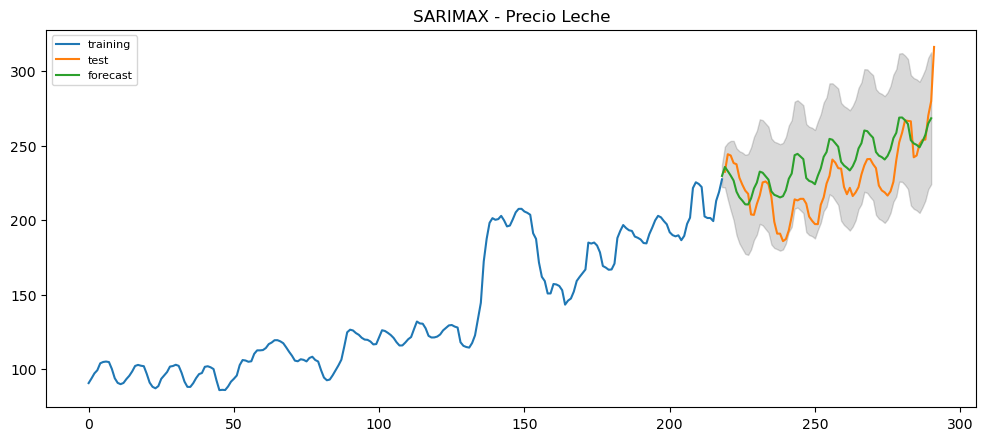

Metric Results:

mape: 0.07399842057257892
corr: 0.793586321733585
min-max: 0.0679262027354256


/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/home/psinet/anaconda3/envs/mlpipeline/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [37]:
n_periods = val_l

fitted, confint = sxmodel.predict(n_periods=n_periods, return_conf_int=True, 
                                  exogenous=test[selected_vars])
index_of_fc = np.arange(train.index[-1], train.index[-1]+n_periods)


# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[y_value], label='training')
plt.plot(test[y_value], label='test')
plt.plot(fitted_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title("SARIMAX - Precio Leche")
plt.legend(loc='upper left', fontsize=8)
plt.show()

print("Metric Results:\n")
forecast_accuracy(fitted_series, test[y_value].values)

##### ¿Qué datos adicionales te gustaría tener?¿Qué datos son necesarios para que este modelo funcione/mejore las métricas?

Información sobre la producción de leche, el numero de vacas lecheras y el consumo de productos lacteos son factores que pueden mejorar la predicción del preción. 

Al observar las métricas, se observa que el modelo SARIMA obtiene un menor MAPE (menor probabilidad de error en las predicciones); tiene una mayor correlación con los datos reales, y el error min-max tambien es menor.

Cualitativamente, el modelo SARIMA es levemente mas preciso que el SARIMAX.

#### ¿Para qué aplicaciones puede servir un modelo de este tipo? En particular, ¿Cómo podría ayudar a combatir el cambio climático?

Este modelo puede ser útil para productores de leche, quienes pueden usar la proyección del precio de la leche para tomar ciertas decisiones, como cuando comprar mas ganado, cuando renovarlo, si expandirse o no (y  cuando), etc.

El precio de la leche se ve afectado por el cambio climático, ya que la producción de leche depende de la cantidad de precipitación. Por lo tanto, si debido al cambio climático disminuyen las precipitaciones, disminuirá tambien la producción de leche, y por ende aumentará su precio. Sin embargo, el precio de la leche no solo depende de factores climáticos.

Por otra parte, es sabido que la industria ganadera afecta al cambio climático debido los gases que expele el ganado. Se pueden aplicar impuestos a la leche para controlar el precio y por ende la demanda y producción de leche, lo que mantendría controlado el nivel gases que expele el ganado a nivel nacional. En este sentido, un modelo de predicción de precio de leche podría ayudar a tomar decisiones respecto al impuesto u otras medidas. Sin embargo, la aplicación de un impuesto afectaría al modelo, el cual no sería tan efectivo debido al cambio en la distribución de los datos.


## Apendice

## Visualizacion de precipitacion

<IPython.core.display.Javascript object>


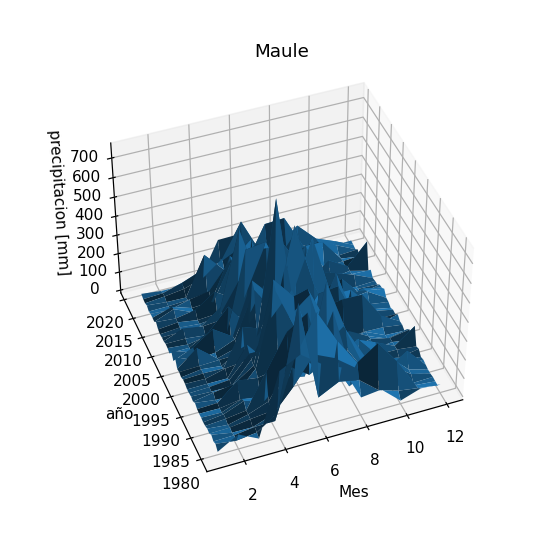

Text(0.5, 0.92, 'Maule')

In [38]:
def filt_by_month(df, months):
    def rule(x, n):
        return x.month in n

    return df[df['fecha'].apply(lambda x: rule(x, months))]

def get_mesh(df, region, init_year=1980, last_year=2019):
    fecha_inicio = pd.to_datetime("%d-01-01" % init_year, format='%Y-%m-%d')
    fecha_termino = pd.to_datetime("%d-12-01" % last_year, format='%Y-%m-%d')
    df_tmp = df[(df['fecha']>=fecha_inicio) & (df['fecha'] <= fecha_termino)]
    
    rows = len(filt_by_month(df_tmp, [1]))
    x = np.arange(1, 13).reshape(-1,1)
    x = np.repeat(x, repeats=rows, axis=1)
    
    y = np.arange(init_year, last_year + 1).reshape(1,-1)
    y = np.repeat(y, repeats=12, axis=0)
    
    z = np.zeros((12, rows))
    for month in range(1, 13):
        month_vec = filt_by_month(df_tmp, [month])[['fecha', region]]
        z[month-1, :] = np.array(month_vec[region])
    
    return x, y, z

from mpl_toolkits.mplot3d import axes3d
from matplotlib import interactive
interactive(True)
%matplotlib notebook

region = 'Maule'
x,y,z = get_mesh(pp, region)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x,y,z)
ax.set_xlabel('Mes')
ax.set_ylabel('año')
ax.set_zlabel('precipitacion [mm]')
ax.set_title(region)